<img src="https://www3.um.edu.uy/logoum.jpg" width=300>
<h1 align="center">Thesis - ALS nDCG</h1> 
<h2 align="center">Alejo Paullier</h2> 

https://lkpy.lenskit.org/en/stable/knn.html

In [2]:
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als
from lenskit.algorithms.als import BiasedMF
from lenskit import topn
import pandas as pd
import numpy as np

ratings = pd.read_csv('C:\\Users\\Alejo\\Tesis\\Demo\\ml-100k\\u.data', sep='\t',
                      names=['user', 'item', 'rating', 'timestamp'])


def eval(aname, algo, train, test):
    fittable = util.clone(algo) # Object cloning means to create an exact copy of the original object.
    fittable = Recommender.adapt(fittable) 
    fittable.fit(train) # Entrenamos el algoritmo con el training dataset
    users = test.user.unique() # Devuelve un array con los users unicos en el testing dataset
    # now we run the recommender
    recs = batch.recommend(fittable, users, 100)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs

In [4]:
def model_trainer(features,reg):
    all_recs = []
    test_data = []
    
    features=int(features)
    als = BiasedMF(features=features, iterations=100, reg=reg, damping=5, bias=True,  progress=None) # define algorithm
    
    for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 5, xf.SampleFrac(0.2)):
        test_data.append(test) # save testing data
        all_recs.append(eval('ALS', als, train, test))
    
    all_recs = pd.concat(all_recs, ignore_index=True)
    test_data = pd.concat(test_data, ignore_index=True)
    rla = topn.RecListAnalysis()
    rla.add_metric(topn.ndcg)
    results = rla.compute(all_recs, test_data)
                          
    return results["ndcg"].mean()

In [5]:
from hyperopt import fmin, tpe, hp, STATUS_OK

def objective(params):
    features = params['features']
    reg = params['reg']
    metric = model_trainer(features,reg)
    print([features,reg,metric],',')
    return {'loss': -metric, 'status': STATUS_OK}

space={'features': hp.uniform('features', 1, 100),
       'reg': hp.uniform('reg',0.01,0.4)}

best = fmin(objective, space, algo=tpe.suggest,max_evals=100)

[78.81812097442621, 0.31424910816675133, 0.13758494559233644]                                                          
,                                                                                                                      
[40.89102481887702, 0.24666000234606078, 0.1318882967413018]                                                           
,                                                                                                                      
[10.009956444703873, 0.36819621285194165, 0.11897103478063932]                                                         
,                                                                                                                      
[70.34392532994366, 0.028243012021208498, 0.13826883743377974]                                                         
,                                                                                                                      
[89.96510029070477, 0.0647616327783368, 

[70.81381970310919, 0.1838140914222731, 0.13992281199334153]                                                           
,                                                                                                                      
[58.84503190006746, 0.21537618278385445, 0.13884681773508342]                                                          
,                                                                                                                      
[64.08689454943362, 0.25219878108897337, 0.13601922378055104]                                                          
,                                                                                                                      
[79.9322070187969, 0.285079477040825, 0.1357392350396056]                                                              
,                                                                                                                      
[52.21996052389362, 0.14918240728232576,

In [7]:
metric = pd.DataFrame(array)
metric.columns = ['features','reg','nDCG']
metric.head(5)

,features,reg,nDCG
0,78.818121,0.314249,0.137585
1,40.891025,0.246660,0.131888
2,10.009956,0.368196,0.118971
3,70.343925,0.028243,0.138269
4,89.965100,0.064762,0.137751


In [8]:
metric.sort_values(by=['nDCG'],ascending=False).head(10)

,features,reg,nDCG
75,56.141376,0.173986,0.143689
36,74.735565,0.140755,0.143235
38,74.086928,0.189947,0.142100
42,72.794117,0.248366,0.141760
64,82.801112,0.096371,0.141402
25,64.507376,0.174993,0.140944
17,64.328946,0.016143,0.140537
23,62.834582,0.356576,0.140381
24,60.851638,0.344715,0.140323
59,61.408329,0.325180,0.140100


In [9]:
metric.to_csv('metric_nDCG.csv', index=False)

In [3]:
metric = pd.read_csv('C:\\Users\\Alejo\\Tesis\\Algoritmos\\Alternating Least Squares\\results\\metric_nDCG.csv', sep=',')

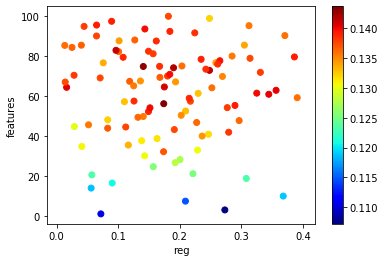

In [5]:
import matplotlib.pyplot as plt
from matplotlib import cm
colormap = cm.hot
x = metric['reg']
y = metric['features'] 
c = metric['nDCG']


fig = plt.figure()
img = plt.scatter(x, y, c=c, cmap=plt.jet())
plt.xlabel('reg')
plt.ylabel('features')
fig.colorbar(img)
plt.show()